In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

### Transfer Learning 

Following this guide https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
(ds_train,ds_test,ds_valid),info = tfds.load('curated_breast_imaging_ddsm/patches', split=['train','test','validation'], shuffle_files=True,
              with_info=True)

In [3]:
num_classes = info.features['label'].num_classes

In [31]:
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE + (3,))
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 100
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 10 #TRAIN_LENGTH // BATCH_SIZE

In [33]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
    input_image = tf.image.grayscale_to_rgb(input_image) # if using pretrained models
    return input_image,datapoint['label']

In [34]:
train_dataset = ds_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
valid_dataset = ds_valid.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Create base model

In [36]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze convolution base
#base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [37]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [38]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
#base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

Training

In [40]:
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=10,
                    validation_data=valid_dataset)

Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 3.1806 - sparse_categorical_accuracy: 0.2736 - val_loss: 1.4567 - val_sparse_categorical_accuracy: 0.4659
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 1.4568 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.4212 - val_sparse_categorical_accuracy: 0.4659
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 1.3858 - sparse_categorical_accuracy: 0.5143 - val_loss: 1.4289 - val_sparse_categorical_accuracy: 0.4659
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 1.4370 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.4139 - val_sparse_categorical_accuracy: 0.4659
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 1.4551 - sparse_categorical_accuracy: 0.4407 - val_loss: 1.4184 - val_sparse_categorical_accuracy: 0.4659
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 1.4374 - sparse_categorical_accuracy: 

Learning curves

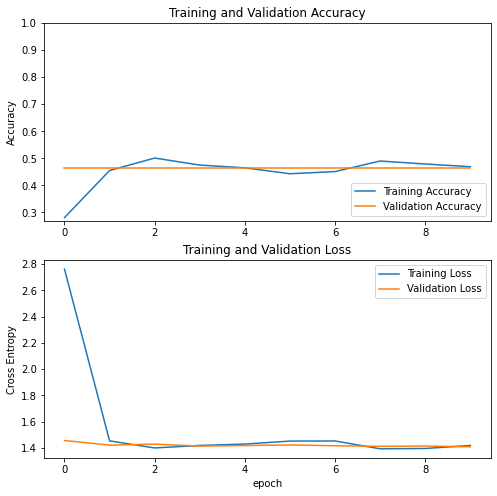

In [44]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()